# 2024 Spring ORF307 Final Project Solutions

Instructor: B. Stellato

AIs: I. Wang, V.Ranjan, J. Smith, P. Beneventano

___

## Instructions
**Exam files:** the exam files are available to download at [THIS LINK.](https://www.dropbox.com/scl/fo/b6an98pypucpvdhb81osz/AHSPIHMuLOtnttr-CDG6ZZY?rlkey=6wph0csyr9gldp2lo7akkx4ln&st=ckxp1xua&dl=0)

**Date and time:** From May 8, 2024 at 00:01 am to May 10, 2024 at 11:59pm.

- Total time after download: 24 hours. No late submissions allowed. Note that the deadline is either 24 hours after download, or May 10, 2024 at 11:59pm, **whichever comes first**.

## Exam Rules
- You are allowed to use all course materials on the midterm (lecture notes, books, precept materials, code, and homeworks). But you cannot use internet to search for answers.
- You have to justify all your answers. If you use code from the course materials, you have to explain what each step means.
- You cannot communicate with anyone during the exam.
- No late submissions allowed. Make sure your submission goes through on time. You can resubmit as many times as you like until your time expires.
- The exam is to be submitted electronically on Gradescope before 11:59pm on the final day.

# Final Exam

## House Price Modeling

You are given data about houses and are tasked with building a model to predict the sell price of these houses. For the data, you have 545 total samples with 11 features:

| Feature          | Description |
| ---------------- | ----------- |
| area             | the area in 1000s of square feet                                  |
| bedrooms         |  the number of bedrooms                                           |
| bathrooms        | the number of bathrooms                                           |
| stories          | the number of stores                                              |
| mainroad         | 1 if the house is connected to the main road and 0 otherwise      |
| guestroom        | the number of guestrooms                                          |
| basement         | 1 if the house has a basement and 0 otherwise                     |
| airconditioning  | 1 if the house has centralized AC and 0 otherwise                 |
| parking          | the number of extra parking spaces                                |
| prefarea         | 1 if the house is located in a 'preferred area' and 0 otherwise   |
| furnished        | 1 if the house comes prefurnished and 0 otherwise                 |

The data also contains a price column, which is the sell price of the house in millions of USD.
For modeling purposes, we split the data into a training and testing set with an 80/20 split.

To model prices, you decide to build a linear model. That is, your goal is to determine a vector of weights $\theta$ to approximately fit: $y \approx X \theta$, where $X$ is the matrix of features and $y$ is the vector of prices. However, your cousin is a realtor and told you that all these features contribute positively to the price of the house. You trust your cousin and you are including this information by enforcing that **all weights in the vector $\theta$ are nonnegative**.

For this project, we will fit the linear model and handle the nonnegativity in a few different ways.

Run the following cells to import the data. Note that after importing the data and separating out $X$ and $y$, we prepend a column of ones to the feature matrices in order to learn an offset.

In [1]:
import numpy as np
np.set_printoptions(precision=4)  # Print few decimal places
np.set_printoptions(suppress=True)  # Suppress scientific notation
import cvxpy as cp
import pandas as pd
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt

In [2]:
dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')
dftrain  # to look at the training dataset

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,airconditioning,parking,prefarea,furnished
0,1.750,3.62,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.695,4.00,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.870,3.04,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.590,3.60,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.515,9.86,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
431,6.790,4.00,3.0,2.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
432,4.305,10.36,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
433,9.800,5.75,3.0,2.0,4.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
434,3.710,3.60,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
Xy_train = dftrain.to_numpy()
Xy_test = dftest.to_numpy()

# prepending a column of ones to both train and test data
X_train = np.column_stack([np.ones(Xy_train.shape[0]), Xy_train[:, 1:]])
y_train = Xy_train[:, 0]
X_test = np.column_stack([np.ones(Xy_test.shape[0]), Xy_test[:, 1:]])
y_test = Xy_test[:, 0]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((436, 12), (436,), (109, 12), (109,))

For this project, whenever you fit a model in any of the parts, make sure that you train the model using the training data (X_train and y_train).
However, when *evaluating* a model, use the normalized train and test errors, which are computed by the following functions:

In [4]:
def normalized_test_error(theta):
  # Test error calculation
    return np.linalg.norm(X_test @ theta - y_test) / np.linalg.norm(y_test)

def normalized_train_error(theta):
    # Training error calculation
    return np.linalg.norm(X_train @ theta - y_train) / np.linalg.norm(y_train)

## Part A: Least Squares (30 Points)

For this part, we will use least squares. After solving any least squares problem, we will postprocess the output by clipping the negative values to zero. This can be done with `theta_clip = np.maximum(theta, 0)`.

1. (10 points) First, we will use least squares to solve the problem. Let the *training residual* be $r = X\theta - y$. That is, we aim to solve the following problem:

$$
\begin{array}{ll}
    \text{minimize} & \| X\theta - y \|_2^2.
\end{array}
$$

Write the equation that you need to solve to compute the optimal solution $\theta^\star$.
Solve the least squares problem over training data `X_train` and `y_train`. Then, clip the negative values of $\theta^\star$ and report the normalized train and test errors.

**Solution**

Let $X$ be X_train and $y$ be y_train.
Assuming $X$ has full column rank, we know the solution is given by the normal equations:
$$
\begin{equation*}
    (X^T X) \theta^\star = X^T y.
\end{equation*}
$$

In [5]:
XTX = X_train.T @ X_train
theta_star = np.linalg.solve(XTX, X_train.T @ y_train)
theta_clip = np.maximum(theta_star, 0)
print(theta_clip)
print('train error:', normalized_train_error(theta_clip))
print('test error:', normalized_test_error(theta_clip))

[0.     0.2502 0.1641 1.0604 0.4385 0.4322 0.3983 0.3453 0.7756 0.2749
 0.6768 0.284 ]
train error: 0.22910437858014016
test error: 0.20796809520319648


2. (10 points) Now, to help with the generalization to the test set, add a secondary objective, with positive weight $\lambda$, that penalizes the squared 2-norm of $\theta$, i.e., $\lambda \|\theta\|_2^2$. Write the equation that you need to solve to compute the optimal $\theta^\star$.

**Solution**
The addition of the regularizer gives the following optimization problem:
$$
\begin{array}{ll}
    \text{minimize} & \| X\theta - y \|_2^2 + \lambda \|\theta \|_2^2.
\end{array}
$$

This is the exact same problem as in Midterm 1, Problem 1 (refer to those solutions for the following derivation). The optimal $\theta^\star$ satisfies:
$$
    (X^TX + \lambda I)\theta^\star = X^T y.
$$

3. (10 points) Form the optimization problem from part A.2 with `X_train` and `y_train`. For each $\lambda \in \{0.1, 1, 10, 100, 1000\}$, solve the problem and clip the negative values $\theta^\star$. Report the normalized train and test error for each value of $\lambda$. What do you notice?

In [6]:
lambd_vals = [0.1, 1, 10, 100, 1000]
def regularized_solve(lambd):
    XTX = X_train.T @ X_train
    XTy = X_train.T @ y_train
    n = XTX.shape[0]
    theta_star = np.linalg.solve(XTX + lambd * np.eye(n), XTy)
    return np.maximum(theta_star, 0)

for lambd in lambd_vals:
    sol = regularized_solve(lambd)
    print(f'lambda = {lambd}, train error = {normalized_train_error(sol)}, test error = {normalized_test_error(sol)}')

lambda = 0.1, train error = 0.22889241908718785, test error = 0.20768086495220503
lambda = 1, train error = 0.22718046993188887, test error = 0.2053338409203083
lambda = 10, train error = 0.21993907106545388, test error = 0.19420966059918723
lambda = 100, train error = 0.22782367939428183, test error = 0.19643049042016344
lambda = 1000, train error = 0.2655501015580773, test error = 0.23545684652459664


We notice that some regularization allows for the best performance on the test set but with too much regularization, we underfit the model and do not perform as well.

## Part B: Linear Programming (35 Points)

Your other cousin, is a consultant and took ORF307 a few years ago. He told you that solving a linear program (LP) works much better for this problem.

1. (5 points) Replace the least squares objective with an $\ell_1$-norm objective on the training residual $r = X\theta - y$, subject to nonnegativity constraints on $\theta$, and add an $\ell_1$-norm penalty on $\theta$ scaled by $\lambda$. Write down the problem you obtain. Next, formulate and solve the problem in CVXPY over training data `X_train` and `y_train`, for $\lambda = 2$, and report the objective and $\theta$ values. Also report the normalized train and test errors.

**Solution**
$$
\begin{array}{ll}
    \text{minimize} & \lVert X\theta - y \rVert_1 + \lambda \|\theta\|_1 \\
    \text{subject to} & \theta \geq 0\\
\end{array}
$$


In [7]:
n_var = X_train.shape[1]
theta = cp.Variable(n_var)

objective = cp.Minimize(cp.norm(X_train@theta - y_train,1) + 2*cp.norm(theta,1))
constraints = [theta >= 0]
problem = cp.Problem(objective,constraints)
problem.solve()
print("Objective value: ", problem.objective.value)
print("theta: ", theta.value)
print("train error :", normalized_train_error(theta.value))
print("test error :", normalized_test_error(theta.value))

Objective value:  358.78621824322914
theta:  [-0.      0.2396  0.1104  0.99    0.4726  0.3587  0.226   0.2545  0.603
  0.1916  0.7438  0.2956]
train error : 0.21972797125747648
test error : 0.19157448612031636


2. (5 points) Write the above problem as an LP.

**Solution**
$$
\begin{array}{ll}
    \text{minimize} & {\bf 1}^Tu + \lambda {\bf 1}^Tz\\
    \text{subject to} & X\theta - y \leq u\\
    & -X\theta + y \leq u\\
    & \theta \leq z\\
    & -\theta \leq z\\
    & \theta \geq 0
\end{array}
$$
We can also simplify this, by observing that $\theta \geq 0$.
$$
\begin{array}{ll}
    \text{minimize} & {\bf 1}^Tu + \lambda {\bf 1}^T\theta\\
    \text{subject to} & X\theta - y \leq u\\
    & -X\theta + y \leq u\\
    & \theta \geq 0
\end{array}
$$

3. (10 points) Take the dual of the LP.

**Solution**
$$
\begin{array}{ll}
    \text{maximize} & -y^Tw_1 + y^Tw_2\\
    \text{subject to} & X^Tw_1 - X^Tw_2 + w_3 - w_4 - w_5 = 0\\
    & -w_1 - w_2 + {\bf 1} = 0 \\
    & -w_3 - w_4 + \lambda {\bf 1}=0\\
    & w_1,w_2,w_3,w_4,w_5 \geq 0
\end{array}
$$
For the simpler version, we have
$$
\begin{array}{ll}
    \text{maximize} & -y^Tw_1 + y^Tw_2\\
    \text{subject to} & X^Tw_1 - X^Tw_2 - w_3 + \lambda {\bf 1} = 0\\
    & -w_1 - w_2 + {\bf 1} = 0 \\
    & w_1,w_2,w_3 \geq 0
\end{array}
$$

4. (5 points) For $\lambda = 2$, solve the primal and dual LPs with cvxpy, and verify the zero duality gap (up to numerical precision). Verify, for the primal, that you obtain the same solution and normalized train and test errors as in B.1. Compare the train and test errors to the ones obtained with least squares in part A.

**Solution**

In [8]:
# Primal LP
aux_shape = X_train.shape[0]
theta = cp.Variable(n_var)
u = cp.Variable(aux_shape)
z = cp.Variable(n_var)

objective = cp.Minimize(cp.sum(u)+2*cp.sum(z))
constraints = [theta >= 0]
constraints += [X_train@theta - y_train <= u, -X_train@theta + y_train <= u]
constraints += [theta <= z, -theta <= z]
problem_primal = cp.Problem(objective,constraints)
problem_primal.solve()
print("Primal objective value: ", problem_primal.objective.value)
print("theta: ", theta.value)
print("train error :", normalized_train_error(theta.value))
print("test error :", normalized_test_error(theta.value))

# Primal LP - simpler version
aux_shape = X_train.shape[0]
theta = cp.Variable(n_var)
u = cp.Variable(aux_shape)

objective = cp.Minimize(cp.sum(u)+2*cp.sum(theta))
constraints = [theta >= 0]
constraints += [X_train@theta - y_train <= u, -X_train@theta + y_train <= u]
problem_primal = cp.Problem(objective,constraints)
problem_primal.solve()
print("Primal objective value: ", problem_primal.objective.value)
print("theta: ", theta.value)
print("train error :", normalized_train_error(theta.value))
print("test error :", normalized_test_error(theta.value))

Primal objective value:  358.78621827602535
theta:  [0.     0.2396 0.1104 0.99   0.4726 0.3587 0.226  0.2545 0.603  0.1916
 0.7438 0.2956]
train error : 0.2197279712706324
test error : 0.19157448600360572
Primal objective value:  358.78621827598784
theta:  [0.     0.2396 0.1104 0.99   0.4726 0.3587 0.226  0.2545 0.603  0.1916
 0.7438 0.2956]
train error : 0.21972797127063604
test error : 0.19157448600359636


In [9]:
# Dual LP
w_1 = cp.Variable(aux_shape)
w_2= cp.Variable(aux_shape)
w_3 = cp.Variable(n_var)
w_4 = cp.Variable(n_var)
w_5 = cp.Variable(n_var)

objective = cp.Maximize(-y_train@w_1 + y_train@w_2)
constraints = [X_train.T@w_1 -X_train.T@w_2 + w_3-w_4-w_5 == 0]
constraints += [-w_1 -w_2 + np.ones(aux_shape) == 0]
constraints += [-w_3 -w_4 + 2*np.ones(n_var) == 0]
constraints +=[w_1 >=0, w_2 >=0, w_3 >=0, w_4 >=0, w_5 >= 0]
problem_dual = cp.Problem(objective,constraints)
problem_dual.solve()
print("Dual objective value: ", problem_dual.objective.value)
print("Duality gap: ", np.linalg.norm(problem_dual.objective.value - problem_primal.objective.value))

# Dual LP - simpler version
w_1 = cp.Variable(aux_shape)
w_2= cp.Variable(aux_shape)
w_3 = cp.Variable(n_var)

objective = cp.Maximize(-y_train@w_1 + y_train@w_2)
constraints = [X_train.T@w_1 -X_train.T@w_2 -w_3 + 2*np.ones(n_var) == 0]
constraints += [-w_1 -w_2 + np.ones(aux_shape) == 0]
constraints +=[w_1 >=0, w_2 >=0, w_3 >=0]
problem_dual = cp.Problem(objective,constraints)
problem_dual.solve()
print("Dual objective value: ", problem_dual.objective.value)
print("Duality gap: ", np.linalg.norm(problem_dual.objective.value - problem_primal.objective.value))

Dual objective value:  358.78621823951084
Duality gap:  3.647699031716911e-08
Dual objective value:  358.78621829043493
Duality gap:  1.4447095963987522e-08


The normalized prediction error (0.1916) is lower than the best prediction error from the l2 solution (0.1942).

5. (6 points) Let's look at the sensitivity of the solution with respect to $\lambda$. Let the $\ell_1$ regularizer be scaled instead by $\lambda + \epsilon$, where $\lambda=2$. Give an expression for the primal optimal solution $p^\star(\epsilon)$ around $\epsilon = 0$, in terms of the variables in B.2 and/or B.3. In terms of global sensitivity, is this expression an upper or lower bound of the true primal solution after perturbing $\lambda$? Explain why. Verify this by plotting the true objective values as well as the estimated objective values, for $\epsilon$ taking 100 values in the range $[-2,40]$ (you can use `np.linspace(-2,40,100)`).

**Solution**
$p^\star(\epsilon) = p^\star(0) +  \epsilon{\bf 1}^T\theta^\star$. This is an upper bound on the true primal solutions, since we switch the primal and the dual when we calculate the global lower bound. (See HW7 Q1).

In [10]:
obj_values = []
train_errors = []
test_errors = []
theta_norms = []
epsvals = np.linspace(-2,40,100)
for val in epsvals:
    theta_new = cp.Variable(n_var)
    u = cp.Variable(aux_shape)
    objective = cp.Minimize(cp.sum(u) + (2+val)*cp.sum(theta_new))
    constraints = [theta_new >= 0]
    constraints += [X_train@theta_new - y_train <= u, -X_train@theta_new + y_train <= u]
    problem = cp.Problem(objective,constraints)
    problem.solve()
    obj_values.append(problem.objective.value)
    train_errors.append(normalized_train_error(theta_new.value))
    test_errors.append(normalized_test_error(theta_new.value))
    theta_norms.append(np.linalg.norm(theta_new.value,1))

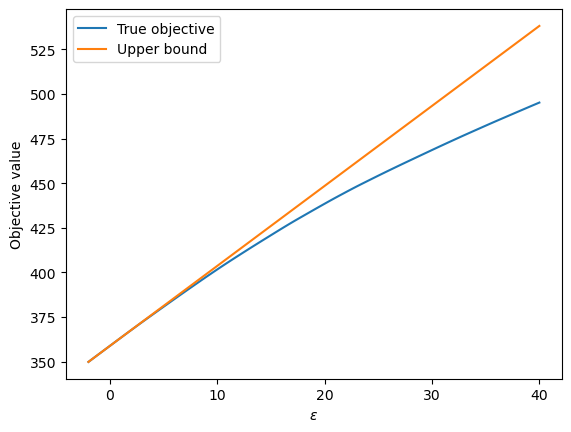

In [11]:
plt.plot(epsvals,obj_values, label = "True objective")
plt.plot(epsvals,[problem_primal.objective.value+np.sum(theta.value)*epsvals[i] for i in range(len(epsvals))], label = "Upper bound")
plt.xlabel(r"$\epsilon$")
plt.ylabel("Objective value")
plt.legend()
plt.show()

6. (4 points) For the set-up in problem B.5, plot the normalized train and test errors for the true optimal solutions, as a function of $\epsilon$ in the range $[-2,40]$. In a separate graph, plot also the 1-norm of the $\theta$ values obtained. Comment on both trends. Do they corroborate your findings from part A?

**Solution**

We see that a regularizer multiplier of around 15 or lower allows for the best performance on the test set. Higher values result in too much emphasis on minimizing the $\theta$ values and less on minimizing the prediction error. This is in line with what we saw in part A.

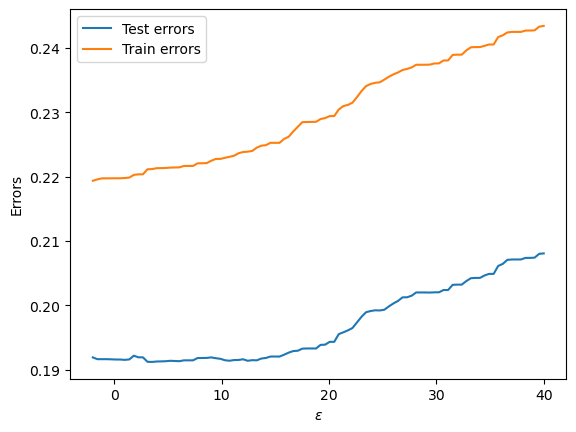

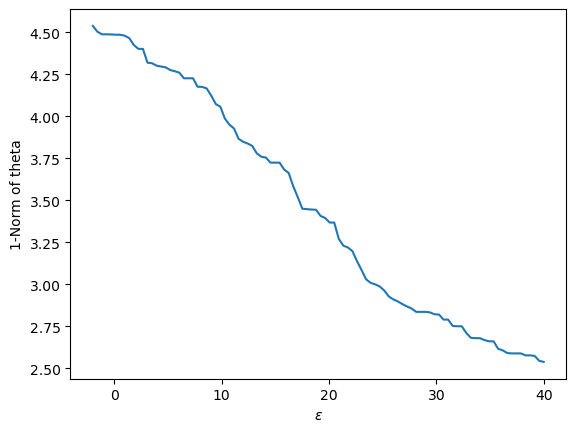

In [12]:
plt.plot(epsvals,test_errors, label='Test errors')
plt.plot(epsvals, train_errors, label='Train errors')
plt.xlabel(r"$\epsilon$")
plt.ylabel("Errors")
plt.legend()
plt.show()
plt.plot(epsvals,theta_norms)
plt.xlabel(r"$\epsilon$")
plt.ylabel("1-Norm of theta")
plt.show()

## Part C: Integer Programming (35 Points)

You are probably smarter than both your cousins and you think that only a few of these features actually matter. For this part, you will impose the constraint that at most $k$ of the values in $\theta$ are strictly positive.

1. (5 points) Formulate the new constraint in terms of the *cardinality* of $\theta$. 
We define cardinality of a vector $\theta$ the number of non-zero components of the vector $\theta$. 
We denote it as $\textbf{card}(\theta)$. 
Write the new optimization problem where we minimize the $\ell_1$-norm of the training residual $r = X\theta - y$, subject to $\theta$ being nonnegative and cardinality of $\theta$ being at most $k$.

**Solution**

The cardinality constraint is given by $$\textbf{card}(\theta) \leq k.$$
The new optimization problem becomes

$$
\begin{array}{ll}
    \text{minimize} & \lVert X\theta - y \rVert_1\\
    \text{subject to} & \theta \geq 0\\
    & \textbf{card}(\theta) \leq k. \\
\end{array}
$$

2. (5 points) Formulate the new problem with the cardinality constraints as a mixed-integer optimization problem (MIP) using the big-$M$ method. You do not need to compute $M$ explicitly; you may just assume that it is a sufficiently large constant.

**Solution**

Letting $p$ be the number of features, we introduce a binary variable vector $t$ and sufficiently large constant $M$ to rewrite the cardinality constraint as
$$
\begin{gather}
    \sum_{i=1}^p t_i \leq k\\
    0 \leq \theta \leq M t \\
    t \in \{0, 1\}^p.
\end{gather}
$$

So, the mixed integer problem becomes:

$$
\begin{array}{ll}
    \text{minimize} & \lVert X\theta - y \rVert_1\\
    \text{subject to} & \theta \geq 0\\
    & \sum_{i=1}^p t_i \leq k \\
    & \theta \leq M t \\
    & t \in \{0, 1\}^p.
\end{array}
$$

3. (10 points) Solve the MIP, over training data `X_train` and `y_train`, for all possible $k \in \{1, 2, \ldots, 11\}$ using the SCIPY (HIGHS) solver (by calling `problem.solve(solver=cp.SCIPY)`) and plot the normalized test and train errors vs k. Use the same solver and the value $M=100$ to solve all the remaining questions in this part.

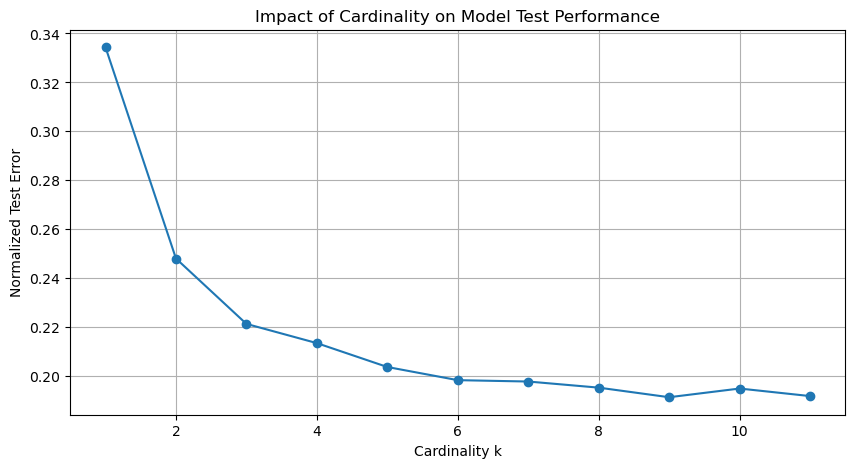

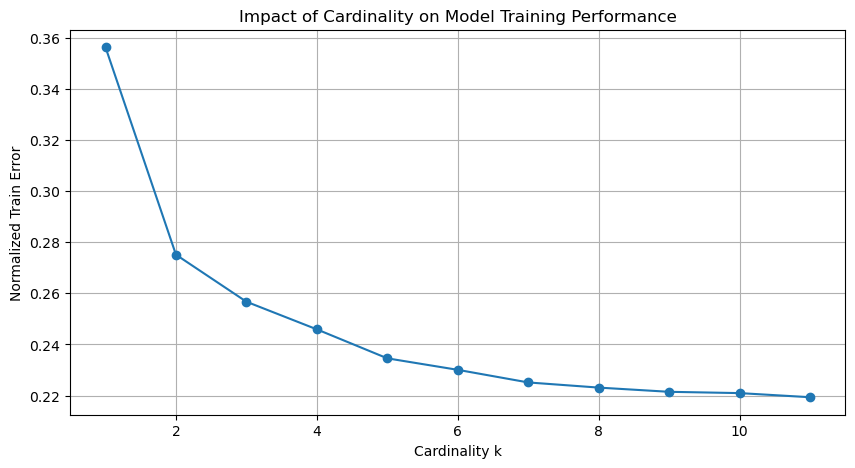

In [13]:
n_var = X_train.shape[1]
test_errors = []
train_errors = []
ks = range(1, n_var)
M = 100

for k in ks:
    theta = cp.Variable(n_var)
    t = cp.Variable(n_var, boolean=True)
    
    # Objective and constraints for MIP
    objective = cp.Minimize(cp.norm(X_train@theta - y_train,1))
    constraints = [theta >= 0,
                   cp.sum(t) <= k,
                   theta <= M * t] 
    
    # Solving the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCIPY)
    
    # Recording the normalized test error
    test_error = normalized_test_error(theta.value)
    test_errors.append(test_error)
    train_error = normalized_train_error(theta.value)
    train_errors.append(train_error)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(ks, test_errors, marker='o')
plt.xlabel('Cardinality k')
plt.ylabel('Normalized Test Error')
plt.title('Impact of Cardinality on Model Test Performance')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ks, train_errors, marker='o')
plt.xlabel('Cardinality k')
plt.ylabel('Normalized Train Error')
plt.title('Impact of Cardinality on Model Training Performance')
plt.grid(True)
plt.show()

In [14]:
print(test_errors)
print(train_errors)

[0.33437046683899757, 0.2480773767621005, 0.2213774912141954, 0.21352642454909024, 0.20377638400437195, 0.1984023486533694, 0.19784398829319144, 0.19534774514054226, 0.19143408400059497, 0.1949831664660871, 0.19190129482703763]
[0.3562532436152561, 0.2750989083856518, 0.25670251179107506, 0.24588950483151983, 0.23455344711846363, 0.230057391478933, 0.22512541325453447, 0.22311009466407533, 0.22146140195621872, 0.22095434479511533, 0.21934395897315764]


4. (10 points) Consider now the $\ell_1$-regression model with a penalty on the number of components, i.e.

$$
\begin{array}{ll}
    \text{minimize} & \lVert X\theta - y \rVert_1 + \lambda \cdot \textbf{card}(\theta) \\
    \text{subject to} & \theta \geq 0.
\end{array}
$$

Formulate the problem with the big-$M$ formulation to represent the cardinality. Find the solution of this problem with CVXPY for 32 evenly spaced $\lambda \in [0,8]$ (you can define the $\lambda$ values with `np.linspace(0, 8, 32)`). Then plot the normalized train and test errors vs $\lambda$ and $\textbf{card}(\theta)$ of the solution found vs $\lambda$. This should take at most a few minutes to run.

**Solution**

*Note: Reformulate the problem as*
$$
\begin{array}{ll}
    \text{minimize} & \lVert X\theta - y \rVert_1 + \lambda 1^\top t \\
    \text{subject to} & \theta \geq 0 \\
    & \theta \leq Mt \\
    & t \in \{0, 1\}^p.
\end{array}
$$
*and solve this one. Use solver=cp.SCIPY.*

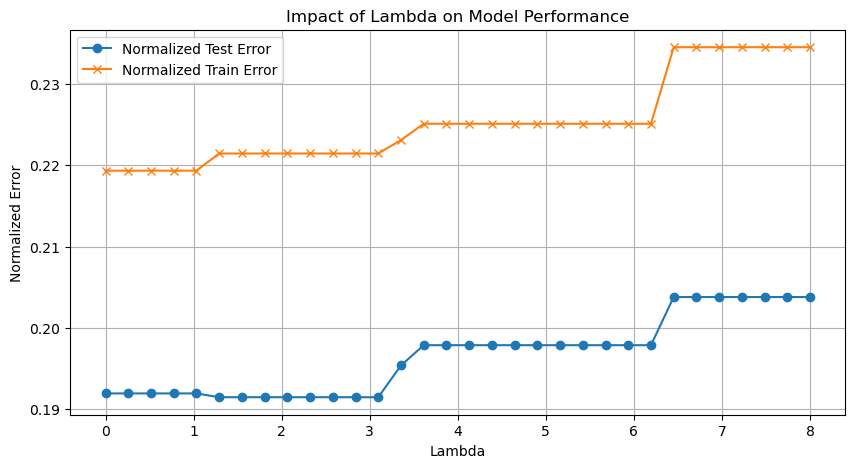

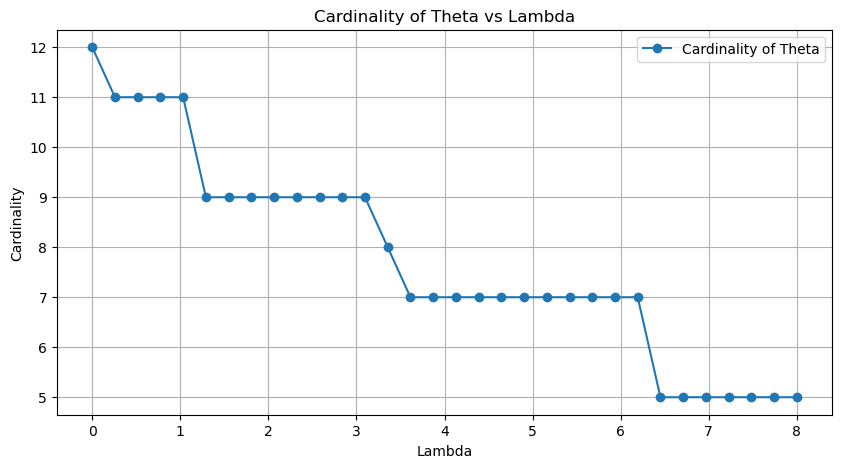

In [15]:
lambdas = np.linspace(0, 8, 32)  # Range of lambda values
test_errors = []
train_errors = []
cardinalities = []
M = 100

for lam in lambdas:
    theta = cp.Variable(n_var)
    t = cp.Variable(n_var, boolean=True)
    
    # Objective: L1-norm of residuals + lambda times L1-norm of theta (sparsity inducing)
    objective = cp.Minimize(cp.norm(X_train @ theta - y_train, 1) + lam * cp.sum(t))
    constraints = [ theta >= 0,  # Non-negativity constraint
                    theta <= M * t,  # Enforcing theta_i is 0 when t_i is 0
                  ]
    
    # Solving the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCIPY)
    
    # Recording the normalized test and train errors
    test_error = normalized_test_error(theta.value)
    train_error = normalized_train_error(theta.value)
    test_errors.append(test_error)
    train_errors.append(train_error)
    
    # Estimating cardinality as the number of significantly non-zero entries
    cardinality = cp.sum(t).value
    cardinalities.append(cardinality)

# Plotting normalized train and test errors vs lambda
plt.figure(figsize=(10, 5))
plt.plot(lambdas, test_errors, marker='o', label='Normalized Test Error')
plt.plot(lambdas, train_errors, marker='x', label='Normalized Train Error')
plt.xlabel('Lambda')
plt.ylabel('Normalized Error')
plt.title('Impact of Lambda on Model Performance')
plt.legend()
plt.grid(True)
plt.show()

# Plotting cardinality of theta vs lambda
plt.figure(figsize=(10, 5))
plt.plot(lambdas, cardinalities, marker='o', label='Cardinality of Theta')
plt.xlabel('Lambda')
plt.ylabel('Cardinality')
plt.title('Cardinality of Theta vs Lambda')
plt.legend()
plt.grid(True)
plt.show()

5. (5 points) Answer the following questions and explain why.
  - What is the trend of the errors, what does it imply? 
  - There is a certain value of $k$ after which the test error decreases only by decrements smaller than 0.01. Which one? What does this mean? Which are the nonzeros of $\theta$ in that case?
  - How does the solution in part C.4 relate to the one in part C.3?

**Solution**

The training error is monotonic in $k$. We could expect this, because adding another feature to the model is only going to make it better. The test error, instead, for $k=9$ components is lower than the one for $k=10$ and $k=11$. This means that there are two components of the data that are only noise and they are not only irrelevant to the output, but they are damaging the model: the regression overfit.

For $k\geq 3$ adding a new features lowers the test error of a value less than $0.01$. We can thus conclude that there are 3 important components for our model.